# Toy Examples

In this notebook we visualize and approximate 1-D and 2-D (nonlinear pendulum) functions.

In [24]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# neural networks
from NN.base import Base as NN_BASE
from NN.linear import Linear as NN_LINEAR
from NN.dense import Dense as NN_DENSE

# gaussian process implementation from bertalan-2019
from GP.gaussian_process import GaussianProcess as GP

# sample where it matters (SWIM) networks
from SWIM.base import Base as SWIM_BASE
from SWIM.linear import Linear as SWIM_LINEAR
from SWIM.dense import Dense as SWIM_DENSE

# some edits for the Hamiltonian approximations
from SWIM_H.base import Base as SWIM_H_BASE
from SWIM_H.linear import Linear as SWIM_H_LINEAR
from SWIM_H.dense import Dense as SWIM_H_DENSE

## **1-D Example**
### Here is the first function that we want to approximate 

$$
  f(x) = \frac{x^{3}}{3} - \frac{x^{2}}{2} - \frac{1}{2} \cos{(x^{2})}
$$

$$
  \frac{\partial f(x)}{\partial x} = x^{2} - x^{2} + \sin{(x^{2})}x
$$

Where $x \in \mathbb{R}$ and $f(x) \in \mathbb{R}$ 

Drawing function using (100,) points.




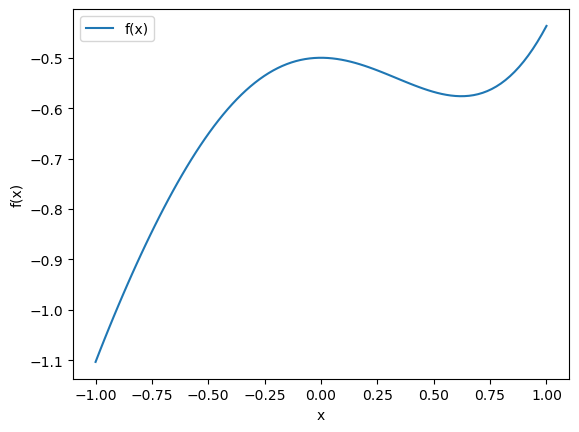

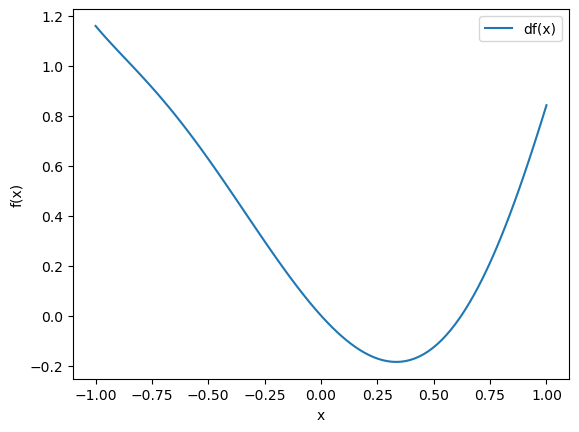

In [6]:
# one dimensional function that we want to approximate as a toy example
def f(x):
    return x**3/3-x**2/2-1/2*np.cos(x**2)
def df(x):
    return x**2-x+np.sin(x**2)*x

# number of points to sample 
N = 100
x = np.linspace(-1, 1, N)
y = f(x)
dx = df(x)

print('Drawing function using', x.shape, 'points.')
fig = plt.figure()
plt.plot(x,y,label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
print()

fig = plt.figure()
plt.plot(x,dx,label='df(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
print()

## Approximation

In the following we always assume that we know the following dataset: $D = \{x_i, dx_i\}_{i = 1}^{K}$ where $dx_i = \frac{df(x)}{dx}(x_i)$ and also the value $f_0 = f(x_0)$ at a single point $x_0 \in \mathbb{R}$,

and we want to be able to approximate $f(x)$ at any $x\ \in \mathbb{R}$, i.e. learn the mapping $f(x)$.

In [22]:
# Sample training dataset
K = 5
x_train_values = np.linspace(-10, 10, K)
x_train_derivs = df(x_train_values)
x0 = np.array([0])
f0 = f(x0)

# Sample points that we want to predict
N = 50
x_predict = np.linspace(-10, 10, N)

### Approximation using the least squares solution
If we use a single Linear layer with $M$ neurons with no activation, which takes the input $x$ and should output $f(x)$ for $x \in \mathbb{R}$, then we can set this up as a system of linear equations for the weights and solve it, since maximizing the likelihood of the weights is same?? as minimizing the least squares error function. 

Since we assume we know the derivatives, we can set up the following system:

Solving a system of $K$ linear equations with $M$ unkowns defined as $\sum_{j=1}^{M}(w_j x_i) = \hat{f}(x_i) \approx f(x_i)$, taking the derivative w.r.t $x$ we get: $\sum_{j=1}^{M}(w_j) = \frac{d\hat{f}(x)}{dx}(x_i) \approx \frac{df(x)}{dx}(x_i)$ which gives us the following system:

$$
w_1 + w_2 + \,...\, + w_M = \frac{d\hat{f}(x)}{dx}(x_1) 
$$
$$
w_1 + w_2 + \,...\, + w_M = \frac{d\hat{f}(x)}{dx}(x_2)
$$
$$
...
$$
$$
w_1 + w_2 + \,..\, + w_M = \frac{d\hat{f}(x)}{dx}(x_K)
$$

which is solving the linear system of equations of $A \, w = \frac{d\hat{f}(x)}{dx}(X)$ for $w$ where $A \in \mathbb{R}^{K \times M}$, $w \in \mathbb{R}^{K}$ and $\frac{d\hat{f}(x)}{dx}(X) \in \mathbb{R}^{K}$ 
$$
A \, w = 
\begin{bmatrix} 1 & 1 & ... & 1 \\ 1 & 1 & ... & 1 \\ \vdots & \vdots & & \vdots \\ 1 & 1 & ... & 1 \end{bmatrix}
\begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_M \end{bmatrix} = \begin{bmatrix} \frac{d\hat{f}(x)}{dx}(x_1) \\ \frac{d\hat{f}(x)}{dx}(x_2) \\ \vdots \\ \frac{d\hat{f}(x)}{dx}(x_K) \end{bmatrix}
$$

We also assume we know an intial value $f_0$ at $x_0$ so we add this linear equation as well. Overall we have the following formulation which we can solve for $w$:
$$
A \, w = 
\begin{bmatrix} 1 & 1 & ... & 1 \\ 1 & 1 & ... & 1 \\ \vdots & \vdots & & \vdots \\ 1 & 1 & ... & 1 \\ x_0 & x_0 & ... & x_0 \end{bmatrix}
\begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_M \end{bmatrix} = \begin{bmatrix} \frac{d\hat{f}(x)}{dx}(x_1) \\ \frac{d\hat{f}(x)}{dx}(x_2) \\ \vdots \\ \frac{d\hat{f}(x)}{dx}(x_K) \\ f_0 \end{bmatrix}
$$

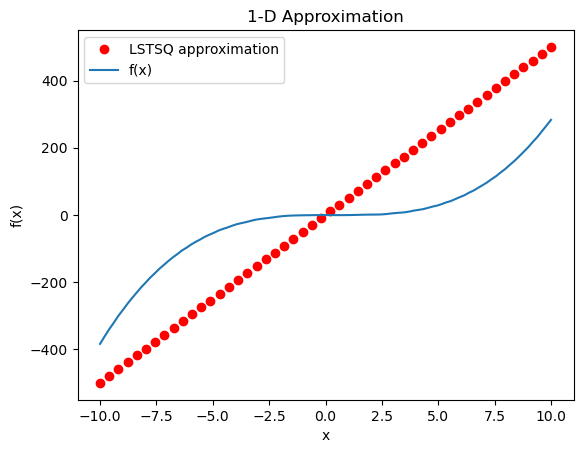

In [23]:
regularization_scale = 1e-8 # for the lstsq
M = 10 # number of hidden nodes, for values >0 it doesn't change the approximation since they add up to a constant anyway

# setup a linear system to approximate the weights: A*w=b
A = np.ones(shape=(K,M))
A = np.vstack([A, np.ones(shape=(M))*x0])
b = np.append(x_train_derivs, f0)

w = np.linalg.lstsq(A, b, rcond=regularization_scale)[0]
def f_lstsqApprox(x):
    return np.tile(x, (M, 1)).T @ w

fx_lstsq_predict = f_lstsqApprox(x_predict)
# Plot linear predictions
# number of points to sample 
N = 100
x = np.linspace(-10, 10, N)
y = f(x)
dx = df(x)

fig = plt.figure()
ax = plt.gca()
ax.set_title('1-D Approximation')
plt.plot(x_predict,fx_lstsq_predict,'ro',markevery=1,label='LSTSQ approximation');
plt.plot(x,y,label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
print()

### Approximation using Shallow NN
If we use a single hidden layer with $M$ neurons with a non-linear activation, which takes the input $x$ and should output $f(x)$ for $x \in \mathbb{R}$ we would get the following approximation $\hat{f}(x_i) = \Phi^{(2)}(x_i) \approx f(x_i)$:

$$
\Phi^{(0)}(x_i) = x_i
$$

$$
\Phi^{(1)}(x_i) = \phi(w_i x_i - b_1)
$$

$$
\Phi^{(2)}(x_i) = \bigg( \sum^{M}_{j=1} \Phi^{(1)}(x_i) \bigg) - b_2 = \bigg( \sum^{M}_{j=1} \phi(w_i x_i) \bigg) - b_2 = \hat{f}(x_i) \approx f(x_i)
$$

where $\Phi^{(l)}$ is the output of the $l$-th layer of the network, with a nonlinear activation function $\phi$ in the hidden layer and identity in the output layer. Since we assume we know the derivatives, we can set up the following custom loss function:

$$
L = \sum_{j=1}^{K} {\bigg( \frac{\partial \hat{f}(x)}{\partial x}(x_i) - \frac{\partial {f}(x)}{\partial x}(x_i) \bigg)}^{2} + (\hat{f}(x_0) - f_0)^{2}
$$

In [ ]:
# we build a pipeline: [Input, Dense, Linear]
n_hidden_layers = 1
activation_name = 'tanh'

steps = [
    ('HIDDEN', NN_DENSE(layer_width=n_hidden_layer, activation=activation_name)), 
    ('OUTPUT', NN_LINEAR()),
]

model = Pipeline(steps=steps, verbose=True)

kxxx (13, 20)
gnew (13, 1)
k_xx (20, 20)
k_x0x (1, 20)
k_grad (1, 13, 20)
mean_grad (13, 20)
f0 (1, 1)
mean_grad (14, 20)
gnew (14, 1)
fx (20, 1)



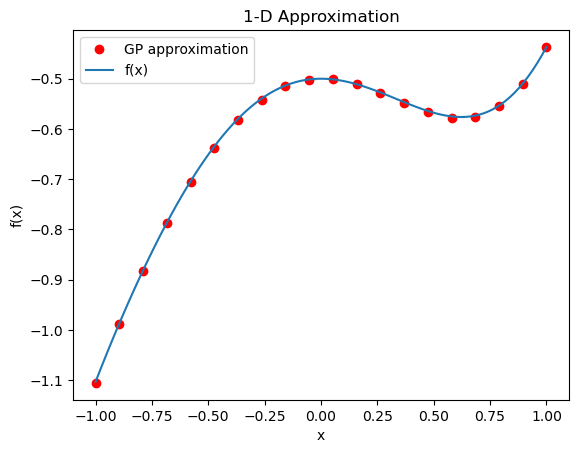

In [3]:
# ELM Model
#elm_model = Ridge(alpha=1e-6)
#elm_model.fit(X_train, y_train)
#y_pred_elm = elm_model.predict(x_range)  # Predict for the entire x_range

# Normal Shallow Network (MLP)
#mlp_model = MLPRegressor(hidden_layer_sizes=(10,), activation='tanh', max_iter=1000, random_state=42)
#mlp_model.fit(X_train, y_train)
#y_pred_mlp = mlp_model.predict(x_range)  # Predict for the entire x_range


# GAUSSIAN PROCESS

# setup GP on a list of points (x) but reshape to have (N,1) dimension
# all inputs here must be of dimension (dimension, 1) for the multi dimension syntax of defined GP
theta = 2
gp = GaussianProcess(x_predict.reshape(-1,1), None, theta=theta)
fx_GP_predict = gp.solve(x0.reshape(-1,1), f0.reshape(-1,1), x_train_values.reshape(-1,1), x_train_derivs.reshape(-1,1), verbose=True)

# Plot GP predictions
fig = plt.figure()
ax = plt.gca()
ax.set_title('1-D Approximation')
plt.plot(x_predict,fx_GP_predict.reshape(N),'ro',markevery=1,label='GP approximation');
plt.plot(x,y,label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
print()

## **2-D Example**

The following function is a Hamiltonian. Therefore let's define our general Hamiltonian system!

A Hamiltonian system is determined through a function called ***Hamiltonian***. 

$$H: E \rightarrow \mathbb{R} $$  

The Hamiltonian incorporates the following set of equations that dictates how a dynamical system changes and evolves over time.  

$$
  \frac{\partial q(t)}{\partial t} = \frac{\partial H(q(t),p(t))}{\partial p} 
$$

$$
  \frac{\partial p(t)}{\partial t} = -\frac{\partial H(q(t),p(t))}{\partial q} 
$$

Where $(q,p) \in \mathbb{R}^{2n}$, and $n$ is the number of degrees of freedom of the system. The equations above can be restated as the following to construct a PDE for $H$ at every $(q,p) \in E $,

$$\begin{bmatrix} 0 & I \\ -I & 0 \end{bmatrix} \cdot \nabla H(q,p) - v(q,p) $$
$$ = \begin{bmatrix} 0 & I \\ -I & 0 \end{bmatrix} \cdot \begin{bmatrix} \frac{\partial H(q,p)}{\partial q} \\ \frac{\partial H(q,p)}{\partial p} \end{bmatrix} - \begin{bmatrix} \frac{\partial q}{\partial t} \\ \frac{\partial p}{\partial t} \end{bmatrix} $$
$$ = \begin{bmatrix} \frac{\partial H(q,p)}{\partial p} \\ -\frac{\partial H(q,p)}{\partial q} \end{bmatrix} - \begin{bmatrix} \frac{\partial q}{\partial t} \\ \frac{\partial p}{\partial t} \end{bmatrix} = 0 $$

where $I \in \mathbb{R}^{n \times n}$ is the identity matrix and $v$ is the vector field on $E$. 

### **Nonlinear Pendulum**

The particular function that we want to approximate is the nonlinear pendulum. This system has only one degree of freedom, i.e. $n = 1$, so $(q,p) \in \mathbb{R}^2$ and the PDE for H is as the following:

The Hamiltonian for this particular system is the following:

$$H: \mathbb{R}^2 \rightarrow \mathbb{R} $$  
$$ H(q,p) = \frac{p^2}{2} + (1 - \cos(q)) $$ 
$$
  \frac{\partial q(t)}{\partial t} = \frac{\partial H(q(t),p(t))}{\partial p} = p
$$
$$
  \frac{\partial p(t)}{\partial t} = -\frac{\partial H(q(t),p(t))}{\partial q} = -\sin(q)
$$


q_grid: (40, 100)
p_grid: (40, 100)
y_grid: (40, 100)
dx_grid: (40, 100, 2)
max{H(x)}: 3.1241910625262124
min{of H(x)}: 0.0007943297143062266





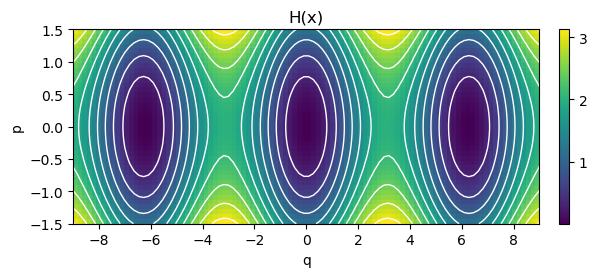

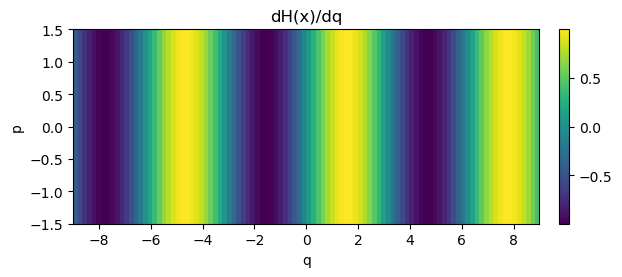

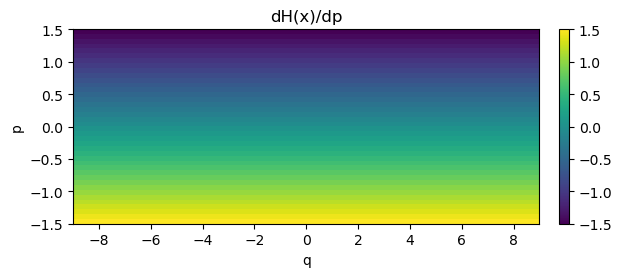

In [21]:
# 2-d Hamiltonian function example that we want to approximate later
def H(x):
    # x is an array of inputs [x_1,x_2,...] where x_i = (q,p) 
    # x_i = (q,p) where q,p are real numbers (1-dimensional) 
    # q := position  
    # p := momentum
    # output is array of values [y_1, y_2, ...] where y_i is a real number (1-dimensional)
    (q,p) = x[:,0], x[:,1]
    return p**2 / 2 + (1 - np.cos(q))
def dH(x):
    # x is same as above
    # output is array of values [y_1, y_2, ...] where y_i = (dH/dq, dH/dp)
    (q,p) = x[:,0], x[:,1]
    dq = np.sin(q)
    dp = p
    return np.array([dq, dp]).T


# We will plot the phase space of our example system 
# to get an overview of the global view of the phase 
# space that we would like to approximate.

# num. of points in the grid, grid dimension is (N_p x N_q)
N_q, N_p = 100, 40
N = N_p * N_q

# set up the grid of size N_q x N_p, q is from set [-9, 9], p is from set [-1.5, 1.5] 
(q_range, p_range) = np.linspace(-9, 9, N_q), np.linspace(-1.5, 1.5, N_p)
q_grid, p_grid = np.meshgrid(q_range, p_range)

# prepare the input x = [ x_1, .., x_{N} ] of shape (N,2) 
x = np.column_stack([q_grid.flatten(), p_grid.flatten()])
y = H(x) # of shape (N,)
dx = dH(x) # of shape (N, 2)

# in order to plot the values, we need to have output of H(x) in
# shape (N_p,N_q), which means we get the value H(x)[i,j] for the 
# grid point at (q_grid[i,j], p_grid[i,j])
y_grid = y.reshape((N_p,N_q))
dx_grid = dx.reshape((N_p,N_q,2))

print('q_grid:', q_grid.shape) # (N_p,N_q)
print('p_grid:', p_grid.shape) # (N_p,N_q)
print('y_grid:', y_grid.shape) # (N_p,N_q)
print('dx_grid:', dx_grid.shape) # (N_p, N_q, 2)
print('max{H(x)}:', np.max(y)) # ~3
print('min{of H(x)}:', np.min(y)) # ~0


# visualize H(x)
fig = plt.figure()
ax = plt.gca()
#im = ax.imshow(y_grid, extent=[-9.0, 9.0, -1.5, 1.5], vmin=0,vmax=3)
im = ax.imshow(y_grid, extent=[-9.0, 9.0, -1.5, 1.5])
#ax.contour(q_range, p_range, np.clip(y_grid, np.floor(np.min(y)), np.ceil(np.max(y))), 10, colors='white', linewidths=1)
ax.contour(q_range, p_range, y_grid, 10, colors='white', linewidths=1)
fig.colorbar(im, ax=ax, fraction=0.049*(N_p / N_q), pad=0.04)
ax.set_ylabel('p')
ax.set_xlabel('q')
ax.set_aspect(2.5)
ax.set_title('H(x)')
print()

# visualize dH/dq
fig = plt.figure()
ax = plt.gca()
im = ax.imshow(dx_grid[:,:,0], extent=[-9.0, 9.0, -1.5, 1.5])
fig.colorbar(im, ax=ax, fraction=0.049*(N_p / N_q), pad=0.04)
ax.set_ylabel('p')
ax.set_xlabel('q')
ax.set_aspect(2.5)
ax.set_title('dH(x)/dq')
print()

# visualize dH/dp
fig = plt.figure()
ax = plt.gca()
im = ax.imshow(dx_grid[:,:,1], extent=[-9.0, 9.0, -1.5, 1.5])
fig.colorbar(im, ax=ax, fraction=0.049*(N_p / N_q), pad=0.04)
ax.set_ylabel('p')
ax.set_xlabel('q')
ax.set_aspect(2.5)
ax.set_title('dH(x)/dp')
print()

## Approximating H(x)

Now we want to approximate the Hamiltonian using sampled networks. For this we need to set up some equations for the sampled Network.